# Convolution Neural Networks for Flow Approximation

In [44]:
import tensorflow as tf
import numpy as np
from help_func import *
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.ndimage.morphology import distance_transform_bf
import random
from PIL import ImageEnhance
from collections import OrderedDict
import os

# Convolution

In [45]:
img_ = Image.open('alberteinstein.png')
img = img_.convert('L')
img = np.array(img)
img = img.reshape([1,500,600,1])
img = img.astype(np.float32)

In [46]:
img.shape

(1, 500, 600, 1)

In [47]:
edge = np.array([-1,-1,-1,-1,8,-1,-1,-1,-1])
edge = edge.reshape([3,3])

sharp = np.array([0,-1,0,-1,1,-1,0,-1,0])
sharp = sharp.reshape([3,3])

In [48]:
filter_ = np.stack([edge,sharp])
filter_ = filter_.reshape([3,3,1,2])

In [49]:
sess = tf.InteractiveSession()
out = tf.nn.conv2d(img,filter=filter_,strides=[1,2,2,1],padding='SAME').eval()
sess.close()

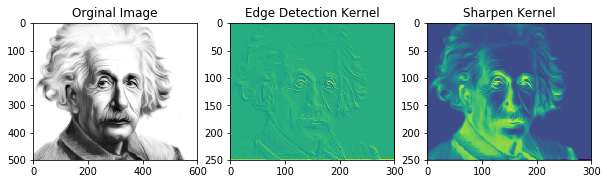

In [50]:
plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('Orginal Image')
plt.imshow(img_)
plt.subplot(132)
plt.title('Edge Detection Kernel')
plt.imshow(out[0,:,:,0])
plt.subplot(133)
plt.title('Sharpen Kernel')
plt.imshow(out[0,:,:,1])

In [51]:
directory = 'final/crop_data/'
input_dict = OrderedDict()
for folder in os.listdir(directory):
    if not folder.startswith('_'):
        file = Image.open(directory+folder+'/input.png')
        label = np.array(file)
        label = distance_transform_bf(label)
        #abel = skfmm.distance(label,dx=0.000002)
        label = range_scaling(label)
        input_dict[folder] = label

# Signed Distance Function

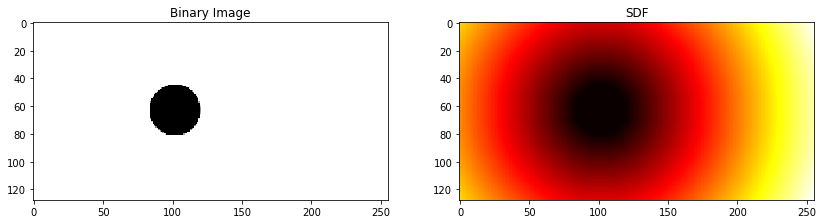

In [52]:
img = Image.open('final/crop_data/cylinder/input.png')
img = np.array(img)
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.title('Binary Image')
plt.subplot(122)
plt.title('SDF')
plt.imshow(input_dict['cylinder'],cmap='hot')
#plt.colorbar()

# CFD simulation data

In [53]:
label_dict = OrderedDict()
u_dict = OrderedDict()
count_dict = OrderedDict()
for folder in os.listdir(directory):
    if not folder.startswith('_') and folder != 'bike':
        file_path = directory+folder
        label_dict[folder],u_dict[folder],count_dict[folder] = get_labels(file_path=file_path) 
    if folder == 'bike':
        file_path = directory+folder
        label_dict[folder],u_dict[folder],count_dict[folder] = get_labels_bike(file_path=file_path) 

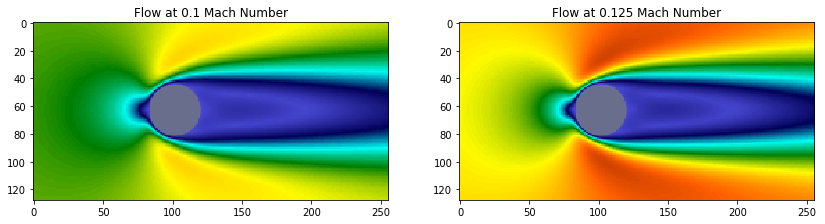

In [54]:
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.title('Flow at 0.1 Mach Number')
plt.imshow(label_dict['cylinder'][0],cmap='jet')
plt.clim((0.1,0.2))
plt.subplot(122)
plt.title('Flow at 0.125 Mach Number')
plt.imshow(label_dict['cylinder'][10],cmap='jet')
plt.clim((0.1,0.2))
#plt.colorbar()

In [80]:
labels = []
features = []
u = []
for key in input_dict.keys():
    labels = labels + list(label_dict[key])
    features = features + [input_dict[key]]*count_dict[key]
    u = u + list(u_dict[key])

u = range_scaling(u)

In [81]:
graph = tf.Graph()

In [82]:
batch_size = 15
filter_size = 8
a = []
gated = True
nonlinearity = set_nonlinearity('relu')
keep_prob=1.0
n_channels = 3

# Network Architecture

In [83]:
with graph.as_default():
    tf_x = tf.placeholder(shape=[batch_size,128,256,1],dtype=tf.float32)
    tf_y = tf.placeholder(shape=[batch_size,128,256,n_channels],dtype=tf.float32)
    
    x = res_block(tf_x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = 2 * filter_size
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, stride=2, gated=gated)
    x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    a.append(x)
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-1], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-2], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-3], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    
    filter_size = int(filter_size /2)
    x = transpose_conv_layer(x, 3, 2, filter_size)
    x = res_block(x, a=a[-4], filter_size=filter_size, nonlinearity=nonlinearity, keep_p=keep_prob, gated=gated)
    
    logits = conv_layer(x, 3, 1, n_channels)
    logits = tf.nn.tanh(logits)
    logits = tf.nn.relu(logits)
    
    loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(logits,tf_y)))
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)


# Training

In [16]:
dont run
sess = tf.InteractiveSession(graph=graph)
file_writer = tf.summary.FileWriter('logs/graph',sess.graph)
tf.global_variables_initializer().run()
for i in range(4000):
    a,b = generate_batch(features,labels,u,n_channels=n_channels,batch_size=batch_size)
    feed_dict = {
        tf_x:a,
        tf_y:b
    }
    _,l = sess.run([optimizer,loss],feed_dict=feed_dict)
    if i%100 ==0:
        print(l)

0.577897
0.33825
0.264015
0.261839
0.230851
0.237632
0.2173
0.218507
0.198424
0.184724
0.189075
0.171543
0.185526
0.159266
0.138411
0.148773
0.127582
0.143251
0.130894
0.108487
0.110905
0.111071
0.0939349
0.0870893
0.110045
0.0958093
0.0897001
0.0877007
0.0817491
0.0837078
0.0884996
0.0760474
0.068332
0.0753802
0.0636416
0.066511
0.0676207
0.0591275
0.0600969
0.0658149


# Testing

In [55]:
a,b = generate_batch(features,labels,u,n_channels=n_channels,batch_size=batch_size)

In [56]:
type_ = 'cylinder'
a[0] = (input_dict['cylinder'] + u[39]).reshape([128,256,1])
b[0] = labels[39]
a[1] = (input_dict['cylinder'] + u[29]).reshape([128,256,1])
b[1] = labels[29]

In [ ]:
g = sess.run(logits,feed_dict={tf_x:a})

In [78]:
sess.r

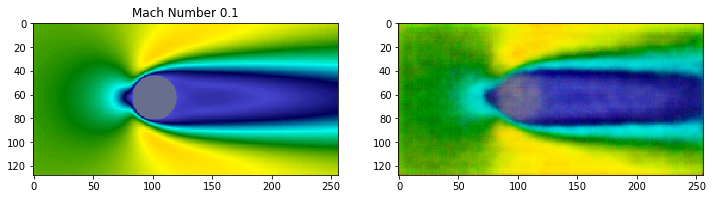

In [77]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title('Mach Number 0.1')
plt.imshow(b[1])
plt.subplot(222)
plt.imshow(g[1])
# plt.subplot(223)

# plt.title('Mach Number 0.125')
# plt.imshow(b[8])
# plt.subplot(224)
# plt.imshow(g[7])

In [41]:
type_ = 'foil_90'
a[0] = input_dict[type_].reshape([128,256,1]) 

In [42]:
g = sess.run(logits,feed_dict={tf_x:a})

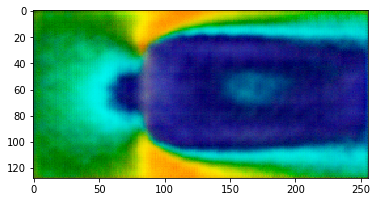

In [61]:
plt.imshow(g[0])

In [ ]:
from scipy.misc import toimage
bike = toimage(bike)
from PIL import ImageFilter
bike.filter(ImageFilter.ModeFilter)

In [ ]:
import cv2
img = cv2.imread('/Users/yeswanthcheekati/Desktop/ard.png')
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plt.figure(figsize=(12,8))
plt.subplot(131),plt.imshow(bike),plt.title('model_prediction')
plt.subplot(132),plt.imshow(ImageEnhance.Sharpness(bike).enhance(0.01)),plt.title('model_prediction_processed')
plt.subplot(133),plt.imshow(b[1]),plt.title('original')
plt.imsave('/Users/yeswanthcheekati/Desktop/sample.png',bike)

In [86]:
saver = tf.train.Saver()

In [88]:
sess = tf.InteractiveSession(graph=graph)